<a href="https://colab.research.google.com/github/danhergir/neuralnet-/blob/main/pytorch_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Network Classification with PyTorch

In [203]:
import sklearn
from sklearn.datasets import make_circles


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [204]:
len(X), len(y)

(1000, 1000)

In [205]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [206]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


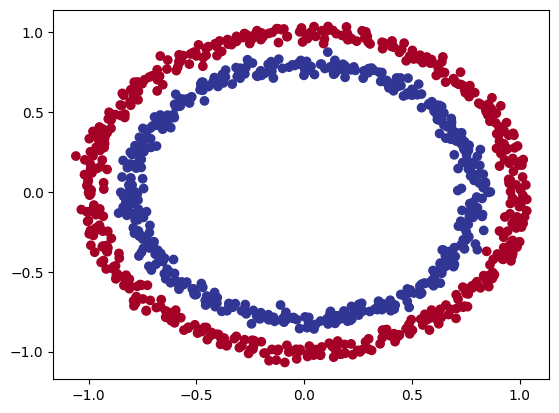

In [207]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

Note: A toy set is a small data set, enough to practice the fundamentals

## Check input and output shapes

In [208]:
X.shape, y.shape

((1000, 2), (1000,))

In [209]:
# View the first example of features and labels

X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## Turn data into tensor and create train and test splits

In [210]:
# Turn data into tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [211]:
# Split data into training and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [212]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:

1. Setup device agnostic code so our code will run on an accelerator (GPU)
2. Construct a model with nn.Module
3. Define a loss function and optimizer
4. Create a training and test loop

In [213]:
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [214]:
X_train.shape

torch.Size([800, 2])

In [215]:
# Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Create 2 nn.Linear layers capable of handling the shapes of our data

    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # in_features here have to match out_features of the previous layer

  # Define forward that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# Instantiate an instance of our model class and send it to the target device

model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [216]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [217]:
 model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5293,  0.6441],
                      [-0.5190,  0.3779],
                      [ 0.2485,  0.2298],
                      [-0.3823,  0.6427],
                      [ 0.1554,  0.0910]])),
             ('0.bias', tensor([-0.6231,  0.2968, -0.1061, -0.3239,  0.6074])),
             ('1.weight',
              tensor([[ 0.0997, -0.2474, -0.2264, -0.0214,  0.2497]])),
             ('1.bias', tensor([-0.1143]))])

In [218]:
# Make predictions with the model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [219]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

## Set up loss function and optimizer

Which loss function or optimizer should I use?

For regression:
MAE or MSE

For classification:
Binary Cross Entropy or Categorical Cross Entropy


The loss function measure how *wrong* our model predictions are

In [220]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [221]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

### 3. Train Model

To train our model, we'll need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimize zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our models are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function.

Then we can convert our model's prediction probabilities to **predictions labels**

In [222]:
# View the first 5 outputs of the forward pass on the test data

model_0.eval()

with torch.inference_mode():
  # Logits are the raw outputs of our model without being passed to an activation function
  y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[-0.1415],
        [-0.1357],
        [-0.0911],
        [-0.1561],
        [ 0.0132]])

In [223]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [224]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs


tensor([[0.4647],
        [0.4661],
        [0.4772],
        [0.4611],
        [0.5033]])

For our prediction probability values, we need to perform a range-style rounding on them:

* y_pred_probs >= 0.5 y = 1 (class 1)
* y_pred_probs < 0.5 y = 0 (class 0)

In [225]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]])

In [226]:
# Find the predicts labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> predit probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of the extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 1.])

## 3.2 Building a training & testing loop

In [227]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop

for epoch in range(epochs):
  # Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate the loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEwithLogitsLoss expects raw logits as input
                 y_train)

  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()

  with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      # 2. Caculate loss/accuracy
      test_loss = loss_fn(test_logits,
                          y_test)
      test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)

  # Print out what's happening every 10 epochs
  if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69443, Accuracy: 45.00% | Test loss: 0.69336, Test acc: 45.50%
Epoch: 10 | Loss: 0.69395, Accuracy: 47.38% | Test loss: 0.69309, Test acc: 48.00%
Epoch: 20 | Loss: 0.69367, Accuracy: 48.00% | Test loss: 0.69302, Test acc: 48.50%
Epoch: 30 | Loss: 0.69349, Accuracy: 48.38% | Test loss: 0.69303, Test acc: 47.00%
Epoch: 40 | Loss: 0.69337, Accuracy: 48.38% | Test loss: 0.69308, Test acc: 47.50%
Epoch: 50 | Loss: 0.69328, Accuracy: 49.00% | Test loss: 0.69316, Test acc: 46.00%
Epoch: 60 | Loss: 0.69321, Accuracy: 49.62% | Test loss: 0.69324, Test acc: 45.00%
Epoch: 70 | Loss: 0.69316, Accuracy: 49.38% | Test loss: 0.69332, Test acc: 43.50%
Epoch: 80 | Loss: 0.69313, Accuracy: 48.62% | Test loss: 0.69340, Test acc: 49.00%
Epoch: 90 | Loss: 0.69310, Accuracy: 48.62% | Test loss: 0.69347, Test acc: 48.50%
Epoch: 100 | Loss: 0.69308, Accuracy: 49.12% | Test loss: 0.69354, Test acc: 47.50%
Epoch: 110 | Loss: 0.69306, Accuracy: 49.50% | Test loss: 0.69361, Test acc: 47.00%
Epo

## 4. Make predictions and evaluate the model

From the metrics it looks like our model is not learning...

In [228]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download


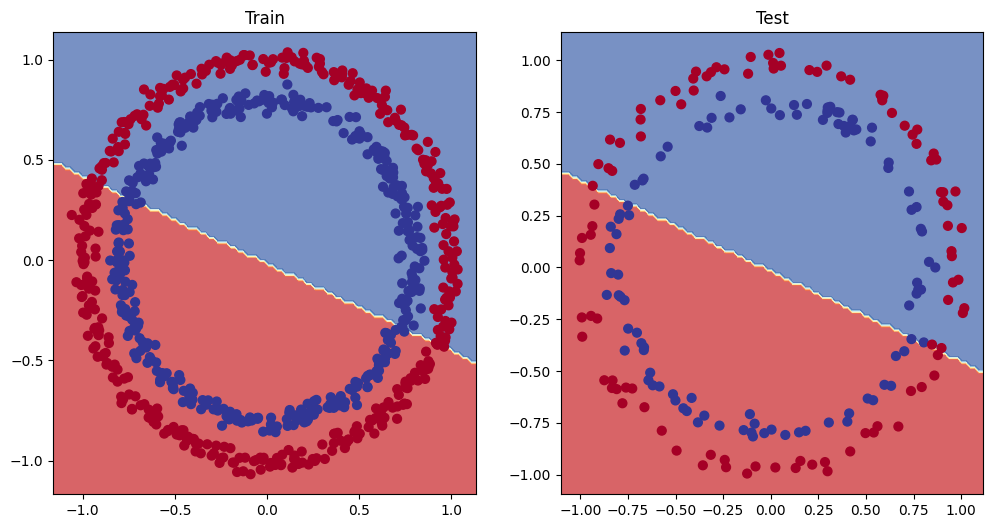

In [229]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

- Add more layers - give the model more chances to learn about the pattern data
- Add more hidden units - go from 5 hidden units to 10 hidden units
- Fit for longer
- Changing the activation function
- Changing the learning rate
- Changing the loss function


Let's try to improve our model by:

* Adding more hidden units
* Increase the number of layers
* Increase the number of epochs

In [230]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)

    return z

model_1 = CircleModelV1().to(device)

In [231]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [232]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [233]:
# Writing a training and evaluation loop for model_1

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing

  model_1.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss
    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's going on
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 100 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 200 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 300 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 400 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 500 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 600 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 700 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 800 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 900 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%


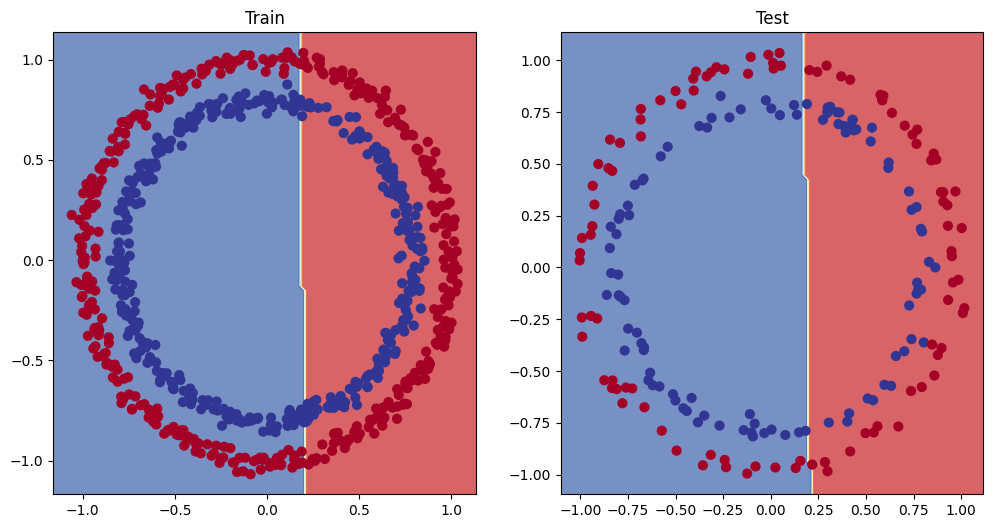

In [234]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test our a smaller problem

In [235]:
# Create some data (same as before)

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilo)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [236]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


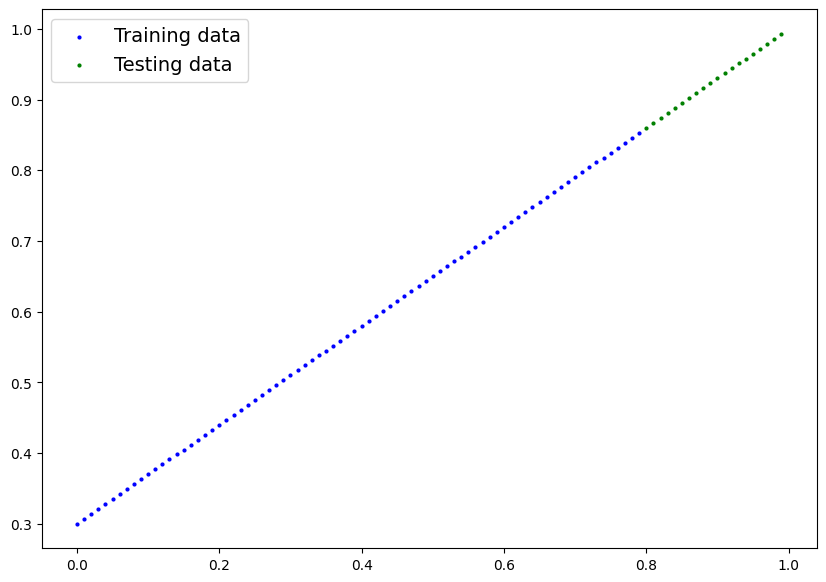

In [237]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
)

In [238]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [239]:
X_train_regression[:5], y_train_regression[:5]

# We have just 1 parameter. That's why we can in the first layer 1 for the 'in_features'

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

## 5.2 Adjusting model_1 to fit a straight line



In [240]:
# Same architecture as model_1 (but using nn.Sequential())

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [241]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr= 0.0001)

In [242]:
# Train the model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

### Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's going on
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.95353
Epoch: 100 | Train loss: 0.72217, Test loss: 0.91073
Epoch: 200 | Train loss: 0.68506, Test loss: 0.86850
Epoch: 300 | Train loss: 0.64848, Test loss: 0.82678
Epoch: 400 | Train loss: 0.61238, Test loss: 0.78551
Epoch: 500 | Train loss: 0.57669, Test loss: 0.74462
Epoch: 600 | Train loss: 0.54137, Test loss: 0.70406
Epoch: 700 | Train loss: 0.50636, Test loss: 0.66376
Epoch: 800 | Train loss: 0.47162, Test loss: 0.62366
Epoch: 900 | Train loss: 0.43710, Test loss: 0.58371


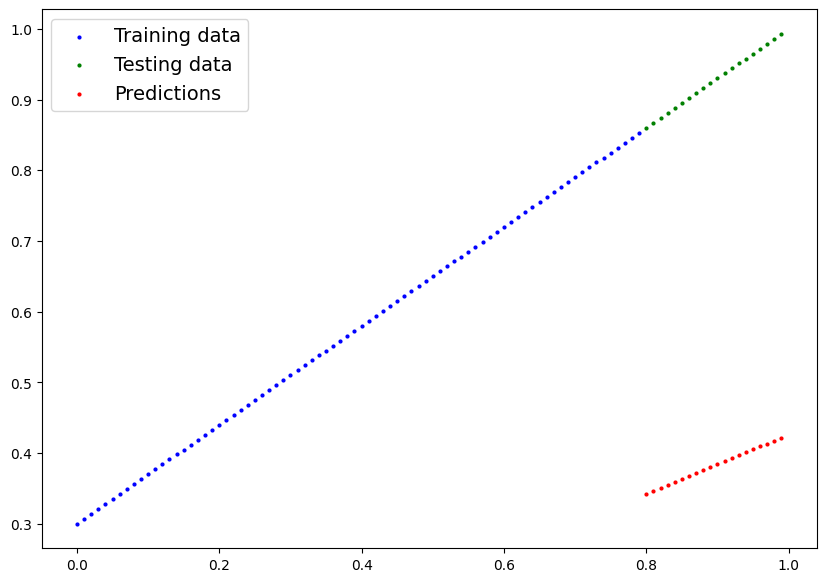

In [243]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

We've seen our model can draw straight (linear) lines, thanks to its linear layers.

But how about we give it the capacity to draw non-straight (non-linear) lines?

How?

Let's find out.

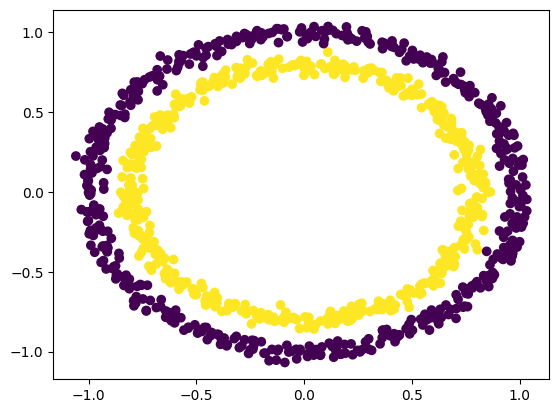

In [244]:
# Recreating non-linear data (red and blue circles)

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [245]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into sensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2 Building a model with non-linearity

Artificial neural networks (ANN) are a large combination of linear(straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [246]:
# Build a model with non-linear activation function

from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # where should we put our non-linear activation function
    z = self.layer_1(x)
    z = self.relu(z)
    z = self.layer_2(z)
    z = self.relu(z)
    z = self.layer_3(z)

    # It's the same as having
    # return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

    return z

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [247]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [248]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.001)

## 6.3 Training a model with non-linearity

In [249]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69441, Accuracy: 50.00% | Test Loss: 0.69373, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69429, Accuracy: 50.00% | Test Loss: 0.69360, Test Accuracy: 50.00%
Epoch: 200 | Loss: 0.69417, Accuracy: 50.00% | Test Loss: 0.69348, Test Accuracy: 50.00%
Epoch: 300 | Loss: 0.69406, Accuracy: 50.00% | Test Loss: 0.69336, Test Accuracy: 50.00%
Epoch: 400 | Loss: 0.69396, Accuracy: 50.00% | Test Loss: 0.69326, Test Accuracy: 50.00%
Epoch: 500 | Loss: 0.69386, Accuracy: 50.00% | Test Loss: 0.69315, Test Accuracy: 50.00%
Epoch: 600 | Loss: 0.69376, Accuracy: 50.00% | Test Loss: 0.69306, Test Accuracy: 50.00%
Epoch: 700 | Loss: 0.69368, Accuracy: 50.00% | Test Loss: 0.69296, Test Accuracy: 50.00%
Epoch: 800 | Loss: 0.69359, Accuracy: 50.00% | Test Loss: 0.69288, Test Accuracy: 50.00%
Epoch: 900 | Loss: 0.69351, Accuracy: 50.00% | Test Loss: 0.69279, Test Accuracy: 50.00%


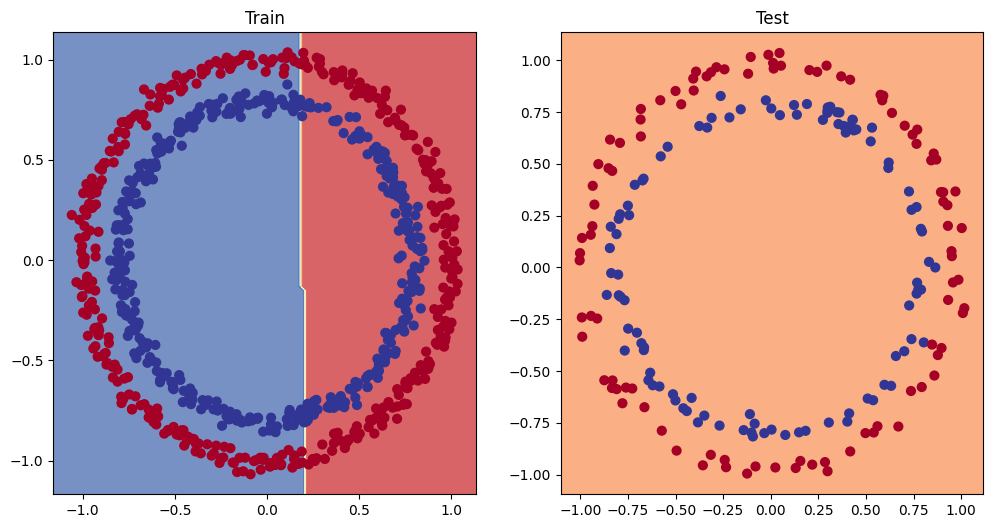

In [250]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## Replicating non-linear activation functions

In [251]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

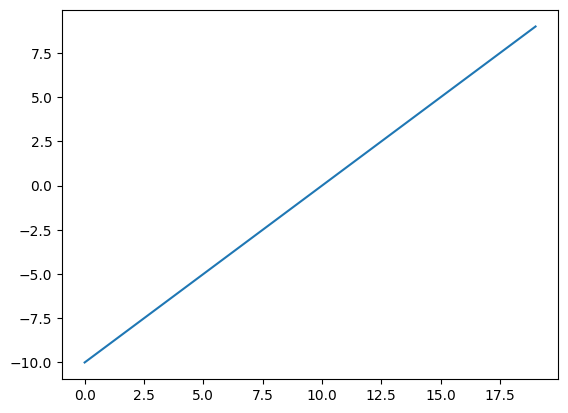

In [252]:
plt.plot(A)

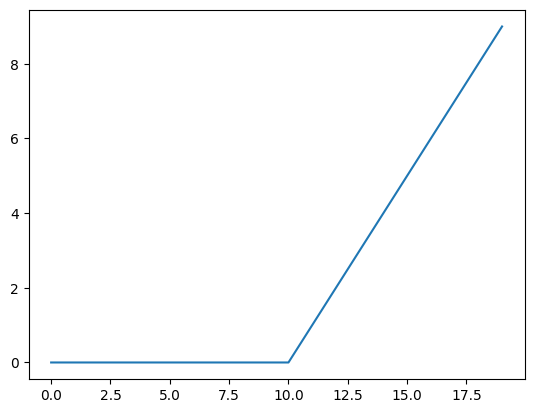

In [253]:
plt.plot(torch.relu(A))

In [254]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0), x) #inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

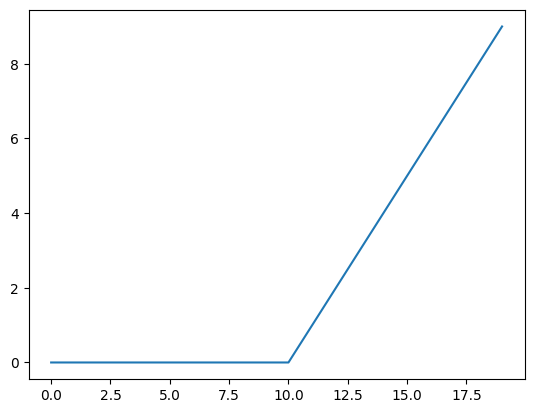

In [255]:
plt.plot(relu(A))

In [256]:
# Replicating sigmoid function

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

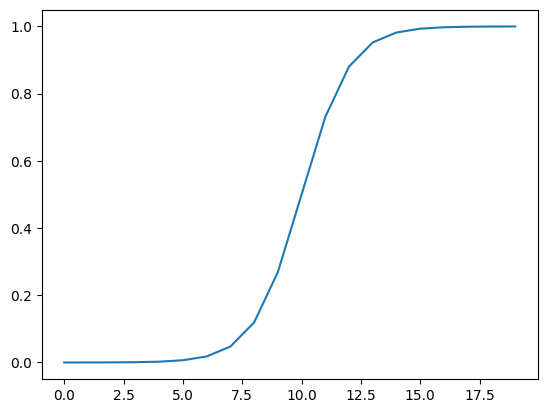

In [257]:
plt.plot(sigmoid(A))

## 8. Putting it all together building a multi-class classification problem

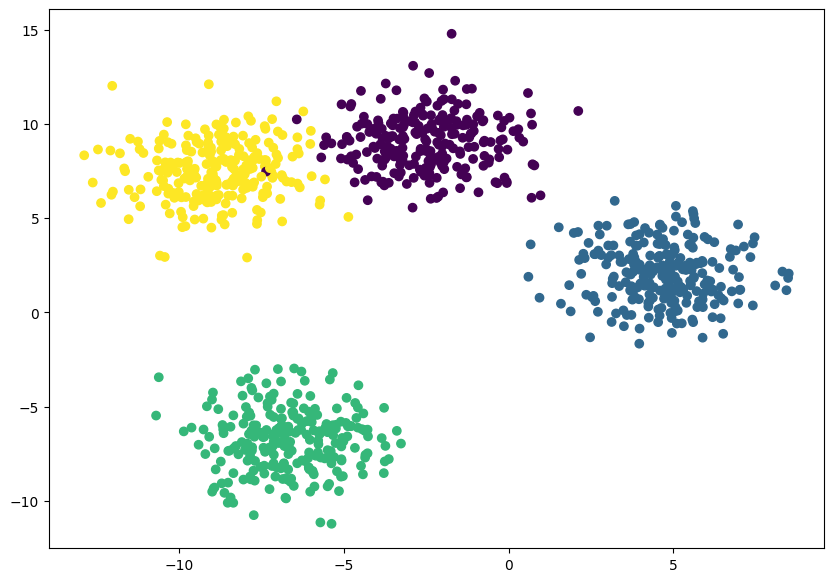

In [327]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the parameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=42)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)

In [328]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [351]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8) -> None:
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
# Create an instance of our model
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [352]:
# Number of unique classes for our multi-class model
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

## Create a loss function and an optimizer for our multi-class model

In [353]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.001)

## Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to predictions probs and then to prediction labels

In [354]:
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10], y_blob_test[:10]

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834],
         [-0.1497, -1.0617, -0.7107, -0.1645],
         [ 0.1539, -0.2887,  0.1520, -0.0109],
         [-0.2154, -1.1795, -0.9300, -0.2745],
         [ 0.2443, -0.2472,  0.1649,  0.0061],
         [-0.2329, -1.2120, -0.9849, -0.3004]]),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

In [355]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_logits[:5], y_pred_probs[:5]

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834]]),
 tensor([[0.3169, 0.3244, 0.1405, 0.2182],
         [0.3336, 0.1432, 0.2026, 0.3206],
         [0.3011, 0.1843, 0.2823, 0.2323],
         [0.3078, 0.2766, 0.1836, 0.2320],
         [0.3719, 0.1286, 0.1532, 0.3463]]))

In [356]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [357]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

## Creating a training and testing loop for a multi-class model

In [360]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
    ### Training 
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### Testing 
    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

        # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.64372, Accuracy: 96.88% | Test Loss: 0.68333, Test Accuracy: 97.00%
Epoch: 100 | Loss: 0.61893, Accuracy: 97.75% | Test Loss: 0.65774, Test Accuracy: 97.50%
Epoch: 200 | Loss: 0.59487, Accuracy: 97.75% | Test Loss: 0.63265, Test Accuracy: 98.00%
Epoch: 300 | Loss: 0.57122, Accuracy: 98.00% | Test Loss: 0.60780, Test Accuracy: 98.00%
Epoch: 400 | Loss: 0.54797, Accuracy: 98.25% | Test Loss: 0.58318, Test Accuracy: 99.50%
Epoch: 500 | Loss: 0.52515, Accuracy: 98.50% | Test Loss: 0.55883, Test Accuracy: 99.50%
Epoch: 600 | Loss: 0.50270, Accuracy: 98.62% | Test Loss: 0.53483, Test Accuracy: 99.50%
Epoch: 700 | Loss: 0.48066, Accuracy: 98.50% | Test Loss: 0.51119, Test Accuracy: 99.50%
Epoch: 800 | Loss: 0.45921, Accuracy: 98.38% | Test Loss: 0.48803, Test Accuracy: 99.50%
Epoch: 900 | Loss: 0.43840, Accuracy: 98.50% | Test Loss: 0.46543, Test Accuracy: 99.50%


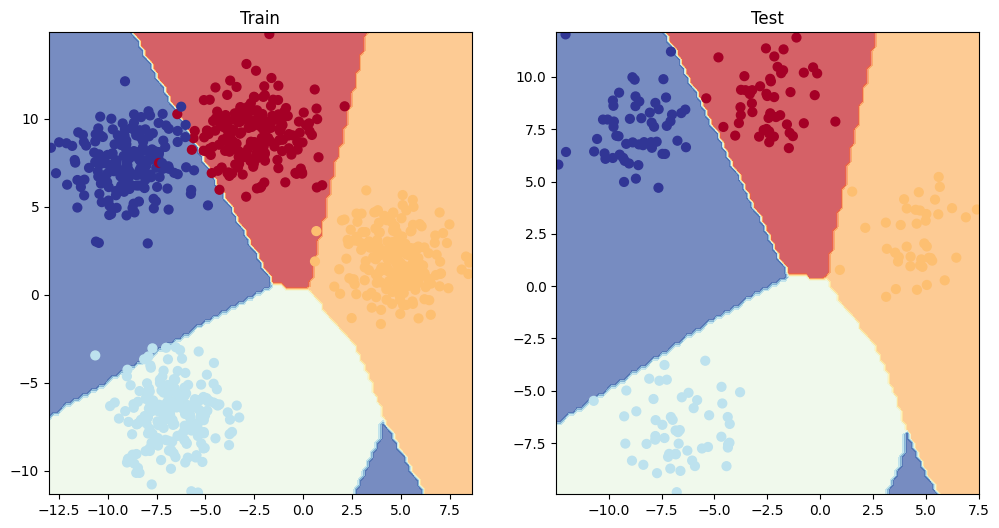

In [361]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## Some other classification metrics